In [0]:
%cd ..
%cd root


/
/root


In [73]:
import pandas as pd
df = pd.read_csv("dwdata_2.csv")
df.head()

,Unnamed: 0,Unnamed: 0.1,X,Y,X_1,Y_1
0,0,0,im pleased you two are so impressed i find the...,yes i suppose the atmosphere is rather rancid,im pleased you two are so impressed i find the...,yes i suppose the atmosphere is rather rancid
1,1,1,hes let us go,he needs to move his tardis into the circle of...,hes let us go,he needs to move his tardis into the circle of...
2,2,2,without special treatment it would have spread...,ah thats nice,without special treatment it would have spread...,ah thats nice
3,3,3,when i came back with these satellite reports ...,nothings been moved,when i came back with these satellite reports ...,nothings been moved
4,4,4,there it is but he could be anywhere,fair exchange is no robbery the masters tempor...,there it is but he could be anywhere,fair exchange is no robbery the masters tempor...


Punctuation has already been removed, all words are lowered. I suppose stemming would not be a nice idea unless we preprocess the data whenever a user enters something. Let's build a simple model then!

In [74]:
import numpy as np
words_x = [""]
words_y = [""]
def word_to_list_x(x):
  words_x.append(str(x).split(" "))
def word_to_list_y(x):
  words_y.append(str(x).split(" "))
df.X.apply(word_to_list_x)
df.Y.apply(word_to_list_y)
words_x1 = [val for sublist in words_x for val in sublist]
words_y1 = [val for sublist in words_y for val in sublist]
words_x = set(words_x1)
words_y = set(words_y1)
print("X:")
print("   # of unique words: {}, Total Words: {}".format(len(words_x), len(words_x1)))
print("Y: ")
print("   # of unique words: {}, Total Words: {}".format(len(words_y), len(words_y1)))
print("Combined: ")
print("   # of unique words: {}, Total Words: {}".format(len(set(list(words_y)+list(words_x))), len(words_y1+words_x1)))
print("Total Training Size: {}".format(len(df)))

X:
   # of unique words: 30793, Total Words: 725045
Y: 
   # of unique words: 37657, Total Words: 939351
Combined: 
   # of unique words: 53382, Total Words: 1664396
Total Training Size: 76543


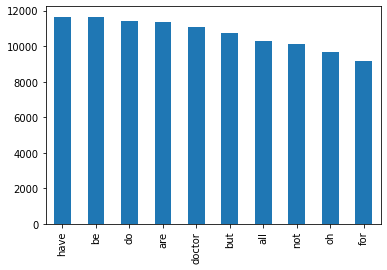

In [75]:
pd.Series(words_y1+words_x1).value_counts()[20:30].plot.bar()

Max words per sentence is 253 as per the last notebook


In [0]:
X = []
Y = []
def remove_num_X(x):
  x = str(x)
  result = ''.join([i for i in x if not i.isdigit()])
  X.append(result)
def remove_num_Y(x):
  x = str(x)
  result = ''.join([i for i in x if not i.isdigit()])
  Y.append(result)
df.X.apply(remove_num_X)
df.Y.apply(remove_num_Y)
df["X_1"] = X
df["Y_1"] = Y

In [77]:
word_freq = pd.Series(words_y1+words_x1).value_counts()
print("Total Number of Unique Words Before: {}".format(len(word_freq)))
ignored = word_freq[word_freq<=4]
word_freq = word_freq[word_freq>4]
print("Total Number of Unique Words After: {}".format(len(word_freq)))

Total Number of Unique Words Before: 53382
Total Number of Unique Words After: 11699


In [0]:
ignored = list(ignored)
X_1 = []
Y_1 = []
def filter_ignored_x(x):
  each_word = x.split(" ")
  result = " ".join([i for i in each_word if i not in ignored])
  X_1.append(result)
def filter_ignored_y(x):
  each_word = x.split(" ")
  result = " ".join([i for i in each_word if i not in ignored])
  Y_1.append(result)
df["X_1"].apply(filter_ignored_x)
df["Y_1"].apply(filter_ignored_y)
df["X_1"] = X_1
df["Y_1"] = Y_1

In [0]:
df.head()

,Unnamed: 0,X,Y,X_1,Y_1
0,0,im pleased you two are so impressed i find the...,yes i suppose the atmosphere is rather rancid,im pleased you two are so impressed i find the...,yes i suppose the atmosphere is rather rancid
1,1,hes let us go,he needs to move his tardis into the circle of...,hes let us go,he needs to move his tardis into the circle of...
2,2,without special treatment it would have spread...,ah thats nice,without special treatment it would have spread...,ah thats nice
3,3,when i came back with these satellite reports ...,nothings been moved,when i came back with these satellite reports ...,nothings been moved
4,4,there it is but he could be anywhere,fair exchange is no robbery the masters tempor...,there it is but he could be anywhere,fair exchange is no robbery the masters tempor...


In [0]:
maxlen = 255
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
all_xy = df["X_1"]
all_xy = all_xy.append(df["Y_1"])
TO = Tokenizer(num_words=20000)
TO.fit_on_texts(all_xy)
X_train = TO.texts_to_sequences(df["X_1"])
Y_train = TO.texts_to_sequences(df["Y_1"])
X_train = pad_sequences(X_train, maxlen=maxlen)
Y_train = pad_sequences(Y_train, maxlen=maxlen)

In [0]:
print(X_train.shape)
print(Y_train.shape)

(76543, 255)
(76543, 255)


In [0]:
df.to_csv("dwdata_2.csv")

//

//

In [2]:
%cd ..
%cd root

/
/root


In [0]:
import pandas as pd
df = pd.read_csv("dwdata_2.csv")

In [0]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Embedding, LSTM, Input, Add, Dense, Flatten, Bidirectional, GlobalMaxPool1D, Dropout
import tensorflow_datasets as tfds
import tensorflow as tf

In [0]:
df.fillna('', inplace=True)

In [0]:
X = df["X_1"].tolist()
Y = df["Y_1"].tolist()

In [0]:
tokenizer_X = tfds.features.text.SubwordTextEncoder.build_from_corpus(
    X, target_vocab_size = 1e15
)
tokenizer_Y = tfds.features.text.SubwordTextEncoder.build_from_corpus(
    Y, target_vocab_size = 1e15
)
vocab_size_en = tokenizer_X.vocab_size+2
vocab_size_pl = tokenizer_Y.vocab_size+2

inputs = [[vocab_size_en-2] + tokenizer_X.encode(sentence) + [vocab_size_en-1] for sentence in df["X_1"]]
outputs = [[vocab_size_pl-2] + tokenizer_Y.encode(sentence) + [vocab_size_pl-1] for sentence in df["Y_1"]]


In [0]:
MAXLEN = 100

In [95]:
vocab_size_en

37092

In [0]:
# Remove long sentences
id2remove = [count for count, sentence in enumerate(inputs) if len(sentence) > MAXLEN]
for idx in reversed(id2remove):
  del inputs[idx]
  del outputs[idx]
id2remove = [count for count, sentence in enumerate(outputs) if len(sentence) > MAXLEN]
for idx in reversed(id2remove):
  del inputs[idx]
  del outputs[idx]

In [97]:
print("{},{}".format(len(inputs), len(outputs)))

76476,76476


In [0]:
ls = [x.split(" ") for x in X]
ls =  [item for sublist in ls for item in sublist]

In [89]:
len(set(ls))

30639

In [0]:
from keras.preprocessing.sequence import pad_sequences
X_train = pad_sequences(inputs, value = 0, maxlen=MAXLEN, padding="post")
Y_train = pad_sequences(outputs, value = 0, maxlen=MAXLEN, padding="post")

In [99]:
print("{},{}".format(X_train.shape,Y_train.shape))
inputs = X_train
outputs = Y_train

(76476, 100),(76476, 100)


In [0]:
BATCH = 64
BUFFER = 20000
ds = tf.data.Dataset.from_tensor_slices((inputs,outputs))
ds = ds.cache()
ds = ds.shuffle(BUFFER).batch(BATCH)
ds = ds.prefetch(tf.data.experimental.AUTOTUNE)

In [0]:
from tensorflow.keras import layers
class PositionalEncoding(layers.Layer):
  def __init__(self):
    super(PositionalEncoding, self).__init__()
  def get_angles(self,pos,i,d_model):
    angles = 1 / np.power(10000.,(2*(i//2))/np.float32(d_model))
    return pos * angles
  def call(self,inputs):
    seq_length = inputs.shape.as_list()[-2]
    d_model = inputs.shape.as_list()[-1]
    angles = self.get_angles(np.arange(seq_length)[:,np.newaxis],
                             np.arange(d_model)[np.newaxis,:],
                             d_model)
    angles[:,0::2] = np.sin(angles[:,0::2])
    angles[:,1::2] = np.cos(angles[:,1::2])
    pos_encoding = angles[np.newaxis,...]
    return inputs + tf.cast(pos_encoding, tf.float32)

In [0]:
def attention_computation(queries,keys,values,mask):
  product = tf.matmul(queries,keys,transpose_b=True)
  keys_dim = tf.cast(tf.shape(keys)[-1],tf.float32)
  scaled_product = product/tf.math.sqrt(tf.cast(keys_dim, tf.float32))
  if mask is not None:
    scaled_product += (mask*-1e9)
  attention = tf.matmul(tf.nn.softmax(scaled_product,axis=-1),values)
  return attention

In [0]:
class MultiHeadAttention(layers.Layer):
  def __init__(self,nb_proj):
    super(MultiHeadAttention, self).__init__()
    self.nb_proj = nb_proj
  def build(self, input_shape):
    self.d_model = input_shape[-1]
    assert self.d_model % self.nb_proj == 0
    self.d_proj = self.d_model // self.nb_proj
    self.query_lin = layers.Dense(units=self.d_model)
    self.key_lin = layers.Dense(units = self.d_model)
    self.value_lin = layers.Dense(units = self.d_model)
    self.final_lin = layers.Dense(units = self.d_model)
  def split_proj (self, inputs, batch_size):
    shape = (batch_size,-1,self.nb_proj,self.d_proj)
    splited_inputs = tf.reshape(inputs,shape=shape)
    return tf.transpose(splited_inputs,perm=[0,2,1,3])
  def call(self,queries,keys,values,mask):
    batch_size = tf.shape(queries)[0]
    queries = self.query_lin(queries)
    keys = self.key_lin(keys)
    values = self.value_lin(values)

    queries = self.split_proj(queries,batch_size)
    keys = self.split_proj(keys,batch_size)
    values = self.split_proj(values,batch_size)

    attention = attention_computation(queries,keys,values,mask)
    attention = tf.transpose(attention, perm=[0,2,1,3])
    concat_attention = tf.reshape(attention, shape=(batch_size,-1,self.d_model))
    outputs = self.final_lin(concat_attention)
    return outputs

In [0]:
class EncoderLayer(layers.Layer):
    def __init__(self, ffn_units, n_heads, dropout):
        super().__init__()
        self.ffn_units=ffn_units
        self.n_heads = n_heads
        self.dropout = dropout
    def build(self, input_shape):
        self.d_model = input_shape[-1]
        self.multi_head_attention = MultiHeadAttention(self.n_heads)
        self.dropout_1 = layers.Dropout(rate=self.dropout)
        self.norm_1 = layers.LayerNormalization(epsilon=1e-6)
        self.dense_1 = layers.Dense(units=self.ffn_units, activation="relu")
        self.dense_2 = layers.Dense(units=self.d_model)
        self.dropout_2 = layers.Dropout(rate=self.dropout)
        self.norm_2 = layers.LayerNormalization(epsilon=1e-6)
    def call(self, inputs, mask, training):
        attention = self.multi_head_attention(inputs,inputs,inputs,mask)
        attention = self.dropout_1(attention, training=training)
        attention = self.norm_1(attention+inputs)
        outputs = self.dense_1(attention)
        outputs = self.dense_2(outputs)
        outputs = self.dropout_2(outputs, training=training)
        outputs = self.norm_2(outputs+attention)
        return outputs
class Encoder(layers.Layer):
    def __init__(self,n_layers,ffn_units,n_heads,dropout,vocab_size,d_model,name="encoder"):
        super().__init__(name=name)
        self.n_layers = n_layers
        self.d_model = d_model
        self.embedding = layers.Embedding(vocab_size, d_model)
        self.pos_encoding = PositionalEncoding()
        self.dropout = layers.Dropout(rate=dropout)
        self.enc_layers = [EncoderLayer(ffn_units, n_heads, dropout) for _ in range(self.n_layers)]
    def call(self, inputs, mask, training):
        outputs = self.embedding(inputs)
        outputs *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        outputs = self.pos_encoding(outputs)
        outputs = self.dropout(outputs, training=training)
        for i in range(self.n_layers):
            outputs = self.enc_layers[i](outputs, mask, training)
        return outputs
class DecoderLayer(layers.Layer):
    def __init__(self, ffn_units, n_heads, dropout):
        super().__init__()
        self.ffn_units = ffn_units
        self.n_heads = n_heads
        self.dropout = dropout
    def build(self, input_shape):
        self.d_model = input_shape[-1]
        self.multi_head_attention_1 = MultiHeadAttention(self.n_heads)
        self.dropout_1 = layers.Dropout(rate=self.dropout)
        self.norm_1 = layers.LayerNormalization(epsilon=1e-6)
        self.multi_head_attention_2 = MultiHeadAttention(self.n_heads)
        self.dropout_2 = layers.Dropout(rate=self.dropout)
        self.norm_2 = layers.LayerNormalization(epsilon=1e-6)
        self.dense_1 = layers.Dense(units=self.ffn_units, activation="relu")
        self.dense_2 = layers.Dense(units=self.d_model)
        self.dropout_3 = layers.Dropout(rate=self.dropout)
        self.norm_3 = layers.LayerNormalization(epsilon=1e-6)
    def call(self, inputs, enc_outputs, mask_1, mask_2, training):
        attention = self.multi_head_attention_1(inputs, inputs, inputs, mask_1)
        attention = self.dropout_1(attention, training=training)
        attention = self.norm_1(attention+inputs)
        attention_2 = self.multi_head_attention_2(attention, enc_outputs, enc_outputs, mask_2)
        attention_2 = self.dropout_2(attention_2, training=training)
        attention_2 = self.norm_2(attention_2+attention)
        outputs = self.dense_1(attention_2)
        outputs = self.dense_2(outputs)
        outputs = self.dropout_3(outputs, training=training)
        outputs = self.norm_3(outputs+attention_2)
        return outputs
class Decoder(layers.Layer):
    def __init__(self,n_layers,ffn_units,n_heads,dropout,vocab_size,d_model,name="decoder"):
        super().__init__(name=name)
        self.d_model = d_model
        self.n_layers = n_layers
        self.embedding = layers.Embedding(vocab_size, d_model)
        self.pos_encoding = PositionalEncoding()
        self.dropout = layers.Dropout(rate=dropout)
        self.dec_layers = [DecoderLayer(ffn_units, n_heads, dropout) for _ in range(n_layers)]
    def call(self, inputs, enc_outputs, mask_1, mask_2, training):
        outputs = self.embedding(inputs)
        outputs *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        outputs = self.pos_encoding(outputs)
        outputs = self.dropout(outputs, training=training)
        for i in range(self.n_layers):
            outputs = self.dec_layers[i](outputs, enc_outputs, mask_1, mask_2, training)
        return outputs

class Transformer(tf.keras.Model):
  def __init__(self,vocab_size_enc,vocab_size_dec,d_model,n_layers,FFN_units,nb_proj,dropout,name="transformer"):
    super(Transformer,self).__init__(name=name)
    self.encoder = Encoder(n_layers,FFN_units,nb_proj,dropout,vocab_size_enc,d_model)
    self.decoder = Decoder(n_layers,FFN_units,nb_proj,dropout,vocab_size_dec,d_model)
    self.last_linear = layers.Dense(units = vocab_size_dec)
  def create_padding_mask(self,seq):
    mask = tf.cast(tf.math.equal(seq,0),tf.float32)
    return mask[:,tf.newaxis,tf.newaxis,:]
  def create_look_ahead_mask(self,seq):
    seq_len = tf.shape(seq)[1]
    look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len,seq_len)),-1,0)
    return look_ahead_mask
  def call(self,enc_inputs,dec_inputs,training):
    enc_mask = self.create_padding_mask(enc_inputs)
    dec_mask_1 = tf.maximum(
        self.create_padding_mask(dec_inputs),
        self.create_look_ahead_mask(dec_inputs)
    )
    dec_mask_2 = self.create_padding_mask(enc_inputs)
    enc_outputs = self.encoder(enc_inputs,enc_mask,training)
    dec_outputs = self.decoder(dec_inputs,
                               enc_outputs,
                               dec_mask_1,
                               dec_mask_2,
                               training)
    outputs = self.last_linear(dec_outputs)
    return outputs


In [0]:
tf.keras.backend.clear_session()
D_MODEL = 128
N_LAYERS = 4
FFN_UNITS = 512
NB_PROJ = 8
DROPOUT = 0.1

transformer = Transformer(vocab_size_enc = vocab_size_en,
                          vocab_size_dec = vocab_size_pl,
                          d_model = D_MODEL,
                          n_layers = N_LAYERS,
                          FFN_units = FFN_UNITS,
                          nb_proj = NB_PROJ,
                          dropout = DROPOUT)
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True,reduction="none")

def loss_function(target,pred):
  mask = tf.math.logical_not(tf.math.equal(target,0))
  loss_ = loss_object(target,pred)
  mask = tf.cast(mask,dtype=loss_.dtype)
  loss_ *= mask
  return tf.reduce_mean(loss_)
train_loss = tf.keras.metrics.Mean(name="train_loss")
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name = "train_accuracy")

class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__ (self,d_model, warmup_steps = 4000):
    super(CustomSchedule,self).__init__()
    self.d_model = tf.cast(d_model,tf.float32)
    self.warmup_steps = warmup_steps
  def __call__ (self,step):
    arg1 = tf.math.rsqrt(tf.cast(step, tf.float32))
    arg2 = step * (self.warmup_steps ** -1.5)
    return  tf.math.rsqrt(tf.cast(self.d_model, tf.float32)) * tf.math.minimum(arg1, arg2)

learning_rate = CustomSchedule(D_MODEL)
optimizer = tf.keras.optimizers.Adam(learning_rate,beta_1 = 0.9, beta_2 = 0.98, epsilon=1e-9)
checkpoint_path = ""
ckpt = tf.train.Checkpoint(transformer=transformer,optimizer=optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt,checkpoint_path,max_to_keep = 5)
if ckpt_manager.latest_checkpoint:
  ckpt.restore(ckpt_manager.latest_checkpoint)
  print("Latest Checkpoint Restored")

In [117]:
import time
epochs = 4
for epoch in range(epochs):
    print("Start of epoch {}".format(epoch+1))
    start = time.time()

    train_loss.reset_states()
    train_accuracy.reset_states()

    for (batch, (enc_inputs, targets)) in enumerate(ds):
        dec_inputs = targets[:, :-1]
        dec_outputs_real = targets[:, 1:]
        with tf.GradientTape() as tape:
            predictions = transformer(enc_inputs, dec_inputs, True)
            loss = loss_function(dec_outputs_real, predictions)

        gradients = tape.gradient(loss, transformer.trainable_variables)
        optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))

        train_loss(loss)
        train_accuracy(dec_outputs_real, predictions)

        if batch % 50 == 0:
            print("Epoch {} Batch {} Loss {:.4f} Accuracy {:.4f}".format(epoch+1, batch, train_loss.result(), train_accuracy.result()))
        
    ckpt_save_path = ckpt_manager.save()
    print("Saving checkpoint for epoch {} at {}".format(epoch+1, ckpt_save_path))
    print("Time taken for 1 epoch {}".format(time.time()-start))

Start of epoch 1
Epoch 1 Batch 0 Loss 1.6541 Accuracy 0.0000
Epoch 1 Batch 50 Loss 1.4269 Accuracy 0.0000
Epoch 1 Batch 100 Loss 1.4041 Accuracy 0.0043
Epoch 1 Batch 150 Loss 1.3992 Accuracy 0.0063
Epoch 1 Batch 200 Loss 1.3833 Accuracy 0.0072
Epoch 1 Batch 250 Loss 1.3577 Accuracy 0.0078
Epoch 1 Batch 300 Loss 1.3292 Accuracy 0.0082
Epoch 1 Batch 350 Loss 1.2902 Accuracy 0.0084
Epoch 1 Batch 400 Loss 1.2560 Accuracy 0.0087
Epoch 1 Batch 450 Loss 1.2211 Accuracy 0.0088
Epoch 1 Batch 500 Loss 1.1890 Accuracy 0.0089
Epoch 1 Batch 550 Loss 1.1626 Accuracy 0.0090
Epoch 1 Batch 600 Loss 1.1380 Accuracy 0.0091
Epoch 1 Batch 650 Loss 1.1182 Accuracy 0.0092
Epoch 1 Batch 700 Loss 1.1000 Accuracy 0.0095
Epoch 1 Batch 750 Loss 1.0838 Accuracy 0.0098
Epoch 1 Batch 800 Loss 1.0701 Accuracy 0.0101
Epoch 1 Batch 850 Loss 1.0575 Accuracy 0.0104
Epoch 1 Batch 900 Loss 1.0453 Accuracy 0.0107
Epoch 1 Batch 950 Loss 1.0336 Accuracy 0.0110
Epoch 1 Batch 1000 Loss 1.0227 Accuracy 0.0113
Epoch 1 Batch 1050 

In [0]:
def evaluate(inp_sentence):
    inp_sentence = inp_sentence.lower()
    inp_sentence = [vocab_size_en - 2] + tokenizer_X.encode(inp_sentence) + [vocab_size_en - 1]
    encoder_inp = tf.expand_dims(inp_sentence, axis=0)
    
    output = tf.expand_dims([vocab_size_pl - 2], axis=0)
    for _ in range(MAXLEN):
        predictions = transformer(encoder_inp, output, False)
        prediction = predictions[:, -1:, :]

        predicted_id = tf.cast(tf.argmax(prediction, axis=-1), tf.float32)

        if predicted_id == vocab_size_pl-1:
            return tf.squeeze(output, axis=0)
        print(output)
        output = tf.concat([output, predicted_id], axis=-1)

    return tf.squeeze(output, axis=0)

In [0]:
def translate(sentence):
    output = evaluate(sentence).numpy()

    predicted_sentence = tokenizer_Y.decode([i for i in output if i < vocab_size_pl-2])

    print("Input sentence: {}".format(sentence))
    print("Translated sentence: {}".format(predicted_sentence))

In [134]:
translate("Hello Doctor I am in danger")

Input sentence: Hello Doctor I am in danger
Translated sentence: oh no no no no no no no no no no no no no no no no no no no no no no no no no no no no no no no no no no no no no no no no no no no no no no no no no no no no no no no no no no no no no no no no no no no no no no no no no no no no no no no no no no no no no no no no no no no no no no no no no no no 


In [138]:
translate("Are you alright mate")

tf.Tensor([[44307]], shape=(1, 1), dtype=int32)


InvalidArgumentError: ignored

In [0]:
#https://github.com/Alt3rius/EN-PL-Transformer/blob/36990ac16478387267e8aa2de90d493fce2fdace/Transformer.ipynb
#https://arxiv.org/pdf/1706.03762.pdf

use embedding, use classic decoder encoder